# Full Variance Budget for Busecke and Abernathey 2017

In this notebook I evaluate the full tracer variance budget for all runs assembled for the 2017 ENSO diffusivity paper.

The full budget (from Abernathey and Marshall 2013) can be written as:

$$ 
\underbrace{\frac{\partial}{\partial t}\frac{\overline{{q^\prime}^2}}{2}}
_\text{tendency} + 
\underbrace{\nabla \cdot \overline{v \frac{{q^\prime}^2}{2}}}
_\text{advection}+ 
\underbrace{\overline{v^\prime q^\prime} \cdot \nabla \overline{q}}
_\text{production}=
\underbrace{\nabla^2 \left({\kappa \overline{ \frac{{q^\prime}^2}{2}}}\right)}
_\text{diffusion} - 
\underbrace{\kappa \overline{|{\nabla q^\prime}|^2}}
_\text{destruction}$$

In [1]:
from dask.distributed import Client
client=Client(scheduler_file='/rigel/home/jb3210/scheduler.json')
client

Client Scheduler: tcp://10.43.4.184:8786 Dashboard: http://10.43.4.184:8787,Cluster Workers: 35 Cores: 140 Memory: 420.00 GB


In [2]:
import xarray as xr
import numpy as np
from xmitgcm import open_mdsdataset
from xgcm import Grid
from os.path import join as pjoin
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# This could potentially be integrated in xmitgcm
def convert_trnum2dimension(ds):
    def drop_nonmatching_vars(ds, var_list):
        data_vars = list(ds.data_vars)
        drop_vars = [a for a in data_vars if a not in var_list]
        return ds.drop(drop_vars)
    
    def rename_vars(ds):
        for vv in list(ds.data_vars):
            ds = ds.rename({vv:vv[0:-2]})
        return ds
        
    tr_num = list(set([a[-2:] for a in list(ds.data_vars)]))
    tr_num.sort()
    tr_vars = list(set([a[:-2] for a in list(ds.data_vars)]))
    
    datasets = [drop_nonmatching_vars(ds, [a+n for a in tr_vars]) for n in tr_num]
    datasets = [rename_vars(b) for b in datasets]
    
    tr_num_int = [int(a) for a in tr_num]
    
    tr_dim = xr.DataArray(tr_num_int, 
                          dims='tracer_no',
                          coords={'tracer_no': (['tracer_no', ], tr_num_int)})
    
    ds_combined = xr.concat(datasets,dim='tracer_no')
    ds_combined['tracer_no'] = tr_dim
    
    return ds_combined

# These should all go to the final version of the github repo

In [4]:
ddir = '/rigel/ocp/users/jb3210/projects/aviso_surface_tracer/runs'

run = 'run_KOC_PSI_variance_budget'
rundir = pjoin(ddir,run)
timestep = 900 # in seconds
chunksize = 1000
readin_dict = dict(delta_t=timestep, swap_dims=True, chunks={'i':chunksize,'j':chunksize,
                                                              'i_g':chunksize,'j_g':chunksize})
kappa = 63

In [5]:
ds = convert_trnum2dimension(open_mdsdataset(rundir,prefix=['tracer_diags'],
                                                  **readin_dict)).persist()
ds

/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:    (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 292, tracer_no: 2)
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XG         (XG) >f4 -2.77556e-17 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 ...
  * YG         (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 -79.5 -79.4 -79.3 ...
  * Z          (Z) float32 -50.0
  * Zp1        (Zp1) float32 0.0 -100.0
  * Zu         (Zu) float32 -100.0
  * Zl         (Zl) float32 0.0
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    dxG        (YG, XC) float32 1930.58 1930.58 1930.58 1930.58 1930.58 ...
    dyG        (YC, XG) float32 11117.7 11117.7 11117.7 11117.7 11117.7 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rAz        (YG, XG) float32 2.14637e+07 2.14637e+07 2.14637e+07 

In [6]:
ds_snap = convert_trnum2dimension(open_mdsdataset(rundir,prefix=['tracer_snapshots'],
                                                  **readin_dict)).persist()
ds_snap

/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:    (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 293, tracer_no: 2)
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XG         (XG) >f4 -2.77556e-17 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 ...
  * YG         (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 -79.5 -79.4 -79.3 ...
  * Z          (Z) float32 -50.0
  * Zp1        (Zp1) float32 0.0 -100.0
  * Zu         (Zu) float32 -100.0
  * Zl         (Zl) float32 0.0
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    dxG        (YG, XC) float32 1930.58 1930.58 1930.58 1930.58 1930.58 ...
    dyG        (YC, XG) float32 11117.7 11117.7 11117.7 11117.7 11117.7 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rAz        (YG, XG) float32 2.14637e+07 2.14637e+07 2.14637e+07 

In [7]:
ds_vel = open_mdsdataset(rundir,prefix=['vel_diags'], **readin_dict).persist()
ds_vel

/rigel/home/jb3210/src/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/rigel/home/jb3210/src/xmitgcm/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 292)
Coordinates:
  * XC       (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 ...
  * YC       (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XG       (XG) >f4 -2.77556e-17 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 ...
  * YG       (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 -79.5 -79.4 -79.3 -79.2 ...
  * Z        (Z) float32 -50.0
  * Zp1      (Zp1) float32 0.0 -100.0
  * Zu       (Zu) float32 -100.0
  * Zl       (Zl) float32 0.0
    rA       (YC, XC) >f4 dask.array<shape=(1600, 3600), chunksize=(1000, 1000)>
    dxG      (YG, XC) >f4 dask.array<shape=(1600, 3600), chunksize=(1000, 1000)>
    dyG      (YC, XG) >f4 dask.array<shape=(1600, 3600), chunksize=(1000, 1000)>
    Depth    (YC, XC) >f4 dask.array<shape=(1600, 3600), chunksize=(1000, 1000)>
    rAz      (YG, XG) >f4 dask.array<shape=(1600, 3600), chunksize=(1000, 1000)>
    dxC      (YC, XG) >f4

In [8]:
# xgcm grid
grid = Grid(ds)

In [22]:
# Variance tendency
delta_t = ds.time[0].values
variance_snap = ds_snap.TRACSQ - (ds_snap.TRAC ** 2)
tend = variance_snap.diff(dim='time') / delta_t
tend

<xarray.DataArray (tracer_no: 2, time: 292, YC: 1600, XC: 3600)>
dask.array<shape=(2, 292, 1600, 3600), dtype=float64, chunksize=(1, 1, 1000, 1000)>
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter       (time) int64 2880 5760 8640 11520 14400 17280 20160 23040 ...
  * time       (time) int64 2592000 5184000 7776000 10368000 12960000 ...

In [23]:
# Variance production
q_mean_gradx = grid.diff(ds['TRAC'], 'X') / ds['dxC'] 
q_mean_grady = grid.diff(ds['TRAC'], 'Y') / ds['dyC'] 

q_pr_u_pr = (ds['UTRAC']-(grid.interp(ds['TRAC'],'X')*ds_vel['UVEL']))
q_pr_v_pr = (ds['VTRAC']-(grid.interp(ds['TRAC'],'Y')*ds_vel['VVEL']))
prod = -(grid.interp((q_pr_u_pr * q_mean_gradx), 'X') + \
        grid.interp((q_pr_v_pr * q_mean_grady), 'Y'))
prod

<xarray.DataArray (tracer_no: 2, time: 292, YC: 1600, XC: 3600)>
dask.array<shape=(2, 292, 1600, 3600), dtype=float32, chunksize=(1, 1, 1000, 1000)>
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * time       (time) int64 2592000 5184000 7776000 10368000 12960000 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...

In [24]:
# Variance diffusion
variance_mean = ds['TRACSQ'] - (ds['TRAC'] ** 2)
uflux_diff = -kappa * grid.diff(variance_mean, 'X') / ds['dxC'] * ds['dyG'] * ds['hFacW']
vflux_diff = -kappa * grid.diff(variance_mean, 'Y') / ds['dyC'] * ds['dxG'] * ds['hFacS']
diff = (grid.diff(uflux_diff, 'X') + grid.diff(vflux_diff, 'Y')) / ds['rA']
diff

<xarray.DataArray (tracer_no: 2, time: 292, YC: 1600, XC: 3600)>
dask.array<shape=(2, 292, 1600, 3600), dtype=float32, chunksize=(1, 1, 1000, 1000)>
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * time       (time) int64 2592000 5184000 7776000 10368000 12960000 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [25]:
# Variance destruction (still not sure how to do this right with the finite volume method)
q_prime_sq_gradx = ds['DXSqTr'] - (q_mean_gradx ** 2)
q_prime_sq_grady = ds['DYSqTr'] - (q_mean_grady ** 2)
dest = -kappa * (grid.interp(q_prime_sq_gradx, 'X') + \
                 grid.interp(q_prime_sq_grady, 'Y'))
dest

<xarray.DataArray (tracer_no: 2, time: 292, YC: 1600, XC: 3600)>
dask.array<shape=(2, 292, 1600, 3600), dtype=float32, chunksize=(1, 1, 1000, 1000)>
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * time       (time) int64 2592000 5184000 7776000 10368000 12960000 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...

In [26]:
#Variance advection
q_on_u = grid.interp(ds['TRAC'], 'X')
q_on_v = grid.interp(ds['TRAC'], 'Y')
u = ds_vel['UVEL']
v = ds_vel['VVEL']
uq = ds['UTRAC']
vq = ds['VTRAC']
uq_sq = ds['UTrSq']
vq_sq = ds['VTrSq']
u_q_pr_sq = uq_sq - u * (q_on_u**2) - (q_on_u*q_pr_u_pr)
v_q_pr_sq = vq_sq - v * (q_on_v**2) - (q_on_v*q_pr_v_pr)
uflux_adve = u_q_pr_sq * ds['dyG'] * ds['hFacW']
vflux_adve = v_q_pr_sq * ds['dxG'] * ds['hFacS']

adve = -(grid.diff(uflux_adve, 'X') + grid.diff(vflux_adve, 'Y')) / ds['rA']
adve = adve

In [27]:
residual = tend-diff+dest+adve+prod
residual

<xarray.DataArray (tracer_no: 2, time: 292, YC: 1600, XC: 3600)>
dask.array<shape=(2, 292, 1600, 3600), dtype=float64, chunksize=(1, 1, 1000, 1000)>
Coordinates:
  * tracer_no  (tracer_no) int64 1 2
  * XC         (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
  * YC         (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
    rA         (YC, XC) float32 2.15699e+07 2.15699e+07 2.15699e+07 ...
    Depth      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hFacC      (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter       (time) int64 2880 5760 8640 11520 14400 17280 20160 23040 ...
  * time       (time) int64 2592000 5184000 7776000 10368000 12960000 ...

In [28]:
# squash all fields into new dimension
budget = xr.concat([a.drop(a.coords) for a in [tend, diff, dest, adve, prod, residual]],
                   dim=['tend', 'diff', 'dest', 'adve', 'prod', 'residual'])
budget = budget.assign_coords(XC=grid._ds.XC)
budget = budget.assign_coords(YC=grid._ds.YC)
budget

<xarray.DataArray (concat_dim: 6, tracer_no: 2, time: 292, YC: 1600, XC: 3600)>
dask.array<shape=(6, 2, 292, 1600, 3600), dtype=float64, chunksize=(1, 1, 1, 1000, 1000)>
Coordinates:
  * concat_dim  (concat_dim) <U8 'tend' 'diff' 'dest' 'adve' 'prod' 'residual'
  * XC          (XC) >f4 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 ...
  * YC          (YC) >f4 -79.95 -79.85 -79.75 -79.65 -79.55 -79.45 -79.35 ...
Dimensions without coordinates: tracer_no, time

In [29]:
budget_snap = budget.isel(time=10, tracer_no=0)

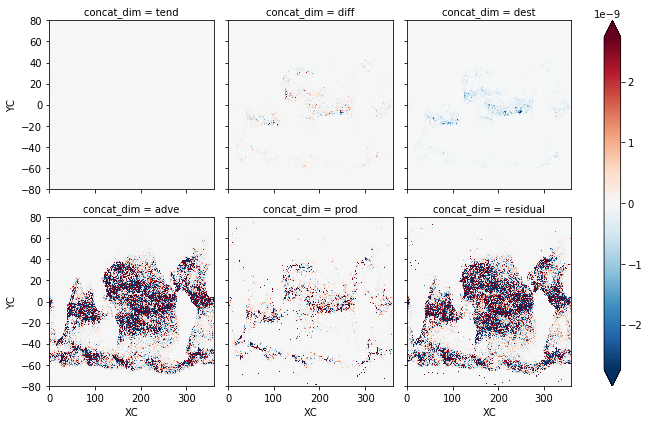

In [30]:
budget_snap.plot(robust=True, col='concat_dim', col_wrap=3)

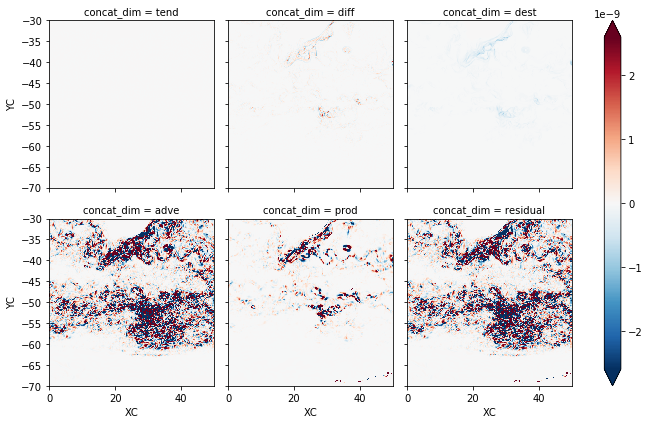

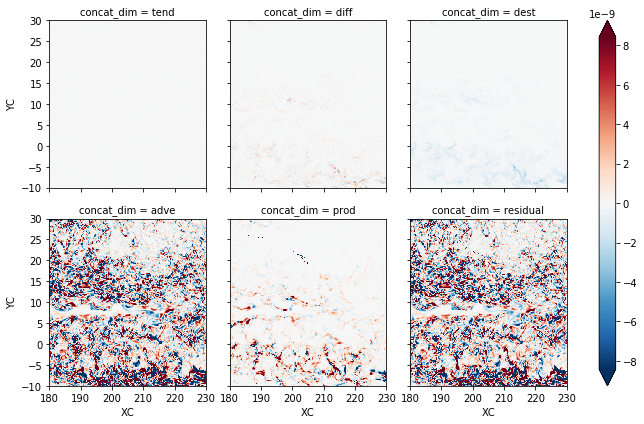

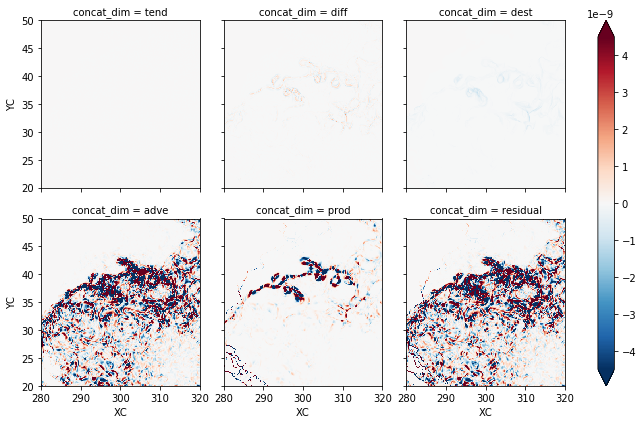

In [31]:
regions = {'agulhas': {'XC': slice(0,50), 'YC': slice(-70, -30)},
           'eq_pacific': {'XC': slice(180, 230), 'YC': slice(-10, 30)},
           'gulf_stream': {'XC': slice(280, 320), 'YC': slice(20, 50)}} 
for re in regions.keys():
    budget_snap.sel(**regions[re]).plot(robust=True, col='concat_dim', col_wrap=3)

In [32]:
budget_mean = budget.isel(tracer_no=0).mean('time').compute()

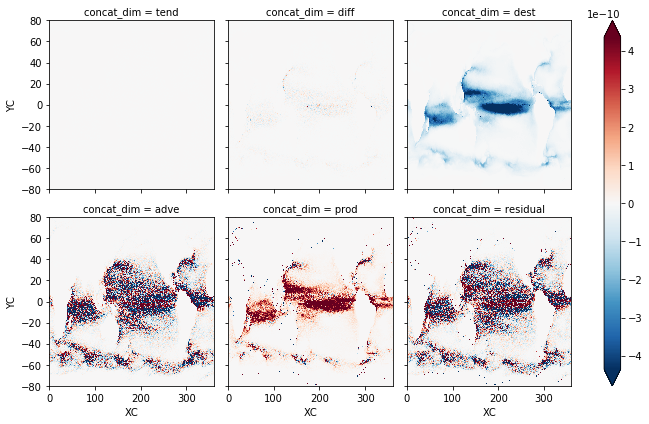

In [33]:
budget_mean.plot(robust=True, col='concat_dim', col_wrap=3)

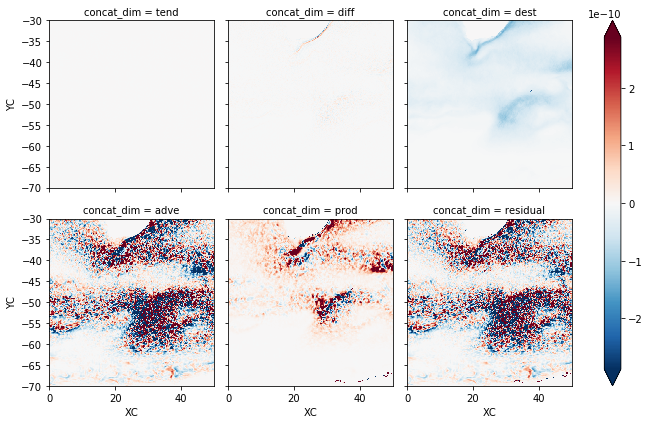

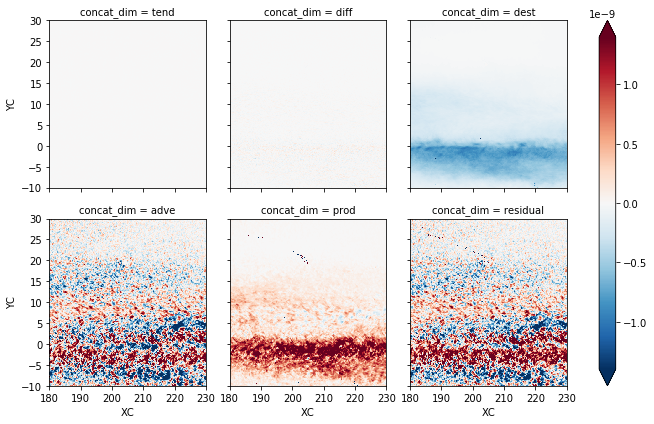

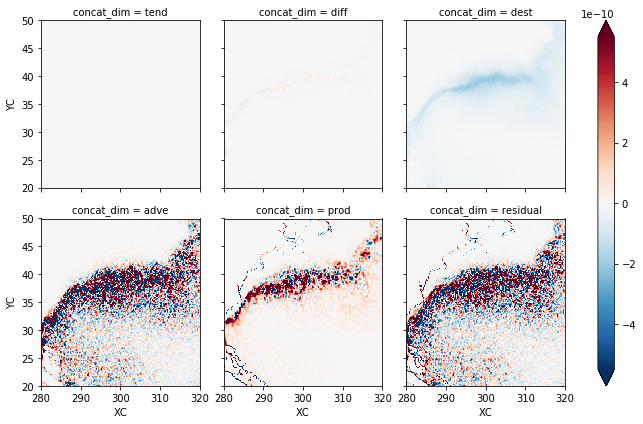

In [34]:
regions = {'agulhas': {'XC': slice(0,50), 'YC': slice(-70, -30)},
           'eq_pacific': {'XC': slice(180, 230), 'YC': slice(-10, 30)},
           'gulf_stream': {'XC': slice(280, 320), 'YC': slice(20, 50)}} 
for re in regions.keys():
    budget_mean.sel(**regions[re]).plot(robust=True, col='concat_dim', col_wrap=3)